In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import pickle
import os

## Data Pre-Processing and Initialization

In [2]:
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        i, images, rows, cols = struct.unpack(">IIII", f.read(16))
        out = np.fromfile(f, dtype=np.uint8).reshape(images, rows*cols)
        return out/255.0

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        i, num_labels = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

In [11]:
train_images = load_mnist_images('dataB/train-images-idx3-ubyte/train-images-idx3-ubyte')
train_labels = load_mnist_labels('dataB/train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images = load_mnist_images('dataB/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels = load_mnist_labels('dataB/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')
train_labels = one_hot_encode(train_labels)
test_labels = one_hot_encode(test_labels)

train_size = int(0.8*len(train_images))
val_size = int(0.1*len(train_images))

X_train, X_val, X_test = train_images[:train_size], train_images[train_size:train_size + val_size], test_images
y_train, y_val, y_test = train_labels[:train_size], train_labels[train_size:train_size + val_size], test_labels

## Neural Network's Class

In [3]:
class NeuralNetwork:
    def __init__(self, N, neurons_size, lr, activation, activation_derivative, weight_init, epochs, batch_size, patience=None):
        self.N = N
        self.neurons_size = neurons_size
        self.lr = lr
        self.activation = activation
        self.activation_derivative = activation_derivative
        self.weight_init = weight_init
        self.epochs = epochs
        self.batch_size = batch_size
        self.patience = patience
        self.weights, self.biases = self.initialize_weights()  
        
    def initialize_weights(self):
        weights = []
        biases = []
        for i in range(len(self.neurons_size)-1):
            inputSize = self.neurons_size[i]
            outputSize = self.neurons_size[i+1]
            weight = self.weight_init((inputSize, outputSize))
            bias = np.zeros((1, outputSize))
            weights.append(weight)
            biases.append(bias)
        return weights, biases
    
    # weight initializations methods
    @staticmethod
    def zero_init(shape):
        return np.zeros(shape)

    @staticmethod
    def random_init(shape):
        l = np.sqrt(1/shape[0]) # scaling factor
        return np.random.uniform(-l, l, size=shape)

    @staticmethod
    def normal_init(shape, mean=0.0, std=1.0):
        std = std*np.sqrt(2 / shape)  # scaling factor
        return np.random.normal(mean, std, size=shape)

    def forwardPropagation(self, X):
        activations = [X]
        for i in range(self.N-2):
            v = np.dot(activations[-1], self.weights[i])+self.biases[i]  # for hidden layer
            z = self.activation(v)
            activations.append(z)
        v = np.dot(activations[-1], self.weights[-1])+self.biases[-1]  # for output layer
        z = self.softmax(v)
        activations.append(z)
        return activations
    
    # activation function methods
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def sigmoid_derivative(x):
        s = NeuralNetwork.sigmoid(x)
        return s * (1 - s)

    @staticmethod
    def tanh(x):
        return np.tanh(x)
    
    @staticmethod
    def tanh_derivative(x):
        return 1 - np.tanh(x)**2

    @staticmethod
    def relu(x):
        return np.clip(np.maximum(0, x), 0, 1e3)  

    @staticmethod
    def relu_derivative(x):
        return np.where(x>0, 1, 0)

    @staticmethod
    def leaky_relu(x, alpha=0.01):
        return np.clip(np.where(x > 0, x, alpha*x), -1e3, 1e3)
    
    @staticmethod
    def leaky_relu_derivative(x, alpha=0.01):
        return np.where(x > 0, 1, alpha)
    
    def softmax(self, z):
        z = z - np.max(z, axis=1, keepdims=True) 
        exp_z = np.exp(z)
        return exp_z / exp_z.sum(axis=1, keepdims=True)

    def backwardPropagation(self, X, y, activations):
        m = y.shape[0]
        deltas = [activations[-1]-y] # predicted - label
        for i in range(self.N-2, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T)*self.activation_derivative(activations[i])
            deltas.insert(0, delta)
        grad_w = []
        grad_b = []
        for i in range(self.N - 1):
            grad_w.append(np.dot(activations[i].T, deltas[i])/m)
            grad_b.append(np.sum(deltas[i], axis=0, keepdims=True)/m)
        return grad_w, grad_b # returning garidents

    def fit(self, X, y, X_val=None, y_val=None):
        global val_loss
        training_losses = []
        validation_losses = []
        best_val_loss = float('inf')
        counter = 0  
        
        for epoch in range(self.epochs):
            epoch_loss = 0
            for i in range(0, X.shape[0], self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y[i:i+self.batch_size]
                activations = self.forwardPropagation(X_batch)
                grads_w, grads_b = self.backwardPropagation(X_batch, y_batch, activations)

                for j in range(self.N - 1): # Weights Updation
                    self.weights[j] -= self.lr * grads_w[j]
                    self.biases[j] -= self.lr * grads_b[j]

                batch_loss = -np.mean(y_batch * np.log(activations[-1] + 1e-9)) # computing batch loss
                epoch_loss += batch_loss

            epoch_loss /= (X.shape[0]/self.batch_size)
            training_losses.append(epoch_loss)

            if X_val is not None and y_val is not None: # Early Stopping condition checker
                val_pred = self.predict_proba(X_val)
                val_loss = -np.mean(y_val*np.log(val_pred+1e-9))
                validation_losses.append(val_loss)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    counter = 0  
                else:
                    counter += 1

                if self.patience and counter >= self.patience:
                    print(f"Early stopping at epoch {epoch} due to no improvement in validation loss.")
                    break

            print(f'Epoch {epoch}, Train Loss: {epoch_loss}', end='')
            if X_val is not None:
                print(f', Validation Loss: {val_loss}')
            else:
                print()
        
        return training_losses, validation_losses

    def predict(self, X):
        probabilities = self.forwardPropagation(X)[-1]
        return np.argmax(probabilities, axis=1)

    def predict_proba(self, X):
        return self.forwardPropagation(X)[-1]

    def score(self, X, y):
        predictions = self.predict(X)
        true_labels = np.argmax(y, axis=1)
        return np.mean(predictions == true_labels)

## Running Process

In [4]:
def run(activation, activation_derivative, init_type, epochs=100, batch_size=128, patience=10):
    filename = f"results_{activation.__name__}_{init_type.__name__}.pkl"

    if os.path.exists(filename): # pickle to save and load data
        with open(filename, "rb") as f:
            experiment_data = pickle.load(f)
        print(f"Loaded results for Activation: {activation.__name__}, Initialization: {init_type.__name__}")
    else:
        nn = NeuralNetwork(
            N=6, 
            neurons_size=[784, 256, 128, 64, 32, 10],
            lr=2e-3,
            activation=activation,
            activation_derivative=activation_derivative,
            weight_init=init_type,
            epochs=epochs,
            batch_size=batch_size,
            patience = patience
        )

        training_losses, validation_losses = nn.fit(X_train, y_train, X_val, y_val)

        test_accuracy = nn.score(X_test, y_test)
        print("Test Accuracy:", test_accuracy)

        plt.figure(figsize=(8, 6))
        epochs_completed = len(training_losses)
        plt.plot(range(epochs_completed), training_losses, label="Training Loss")
        plt.plot(range(epochs_completed), validation_losses, label="Validation Loss")
        plt.title(f"Loss - Activation: {activation.__name__}, Init: {init_type.__name__}")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        plot_filename = f"{activation.__name__}_{init_type.__name__}_loss_plot.png"
        plt.savefig(plot_filename)
        plt.show()

        experiment_data = {
            'test_accuracy': test_accuracy,
            'training_losses': training_losses,
            'validation_losses': validation_losses,
            'plot_filename': plot_filename
        }
        with open(filename, "wb") as f:
            pickle.dump(experiment_data, f)

    print(f"Activation: {activation.__name__}, Initialization: {init_type.__name__}")
    print(f"Test Accuracy: {experiment_data['test_accuracy']:.4f}")

    if os.path.exists(experiment_data['plot_filename']):
        img = plt.imread(experiment_data['plot_filename'])
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Loss Plot - Activation: {activation.__name__}, Init: {init_type.__name__}")
        plt.show()
    
    return experiment_data['test_accuracy'], experiment_data['training_losses'], experiment_data['validation_losses']


## Calling and Output

In [6]:
activation = [
    (NeuralNetwork.sigmoid, NeuralNetwork.sigmoid_derivative),
    (NeuralNetwork.tanh, NeuralNetwork.tanh_derivative),
    (NeuralNetwork.relu, NeuralNetwork.relu_derivative), 
    (NeuralNetwork.leaky_relu, NeuralNetwork.leaky_relu_derivative)
]

weights_init = [
    NeuralNetwork.zero_init, 
    NeuralNetwork.random_init, 
    NeuralNetwork.normal_init
]

Loaded results for Activation: sigmoid, Initialization: zero_init
Activation: sigmoid, Initialization: zero_init
Test Accuracy: 0.1135


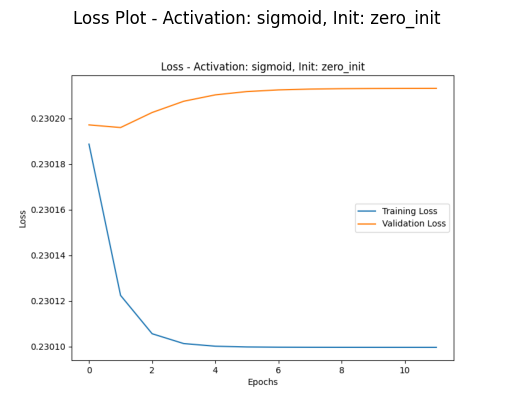

Loaded results for Activation: sigmoid, Initialization: random_init
Activation: sigmoid, Initialization: random_init
Test Accuracy: 0.1135


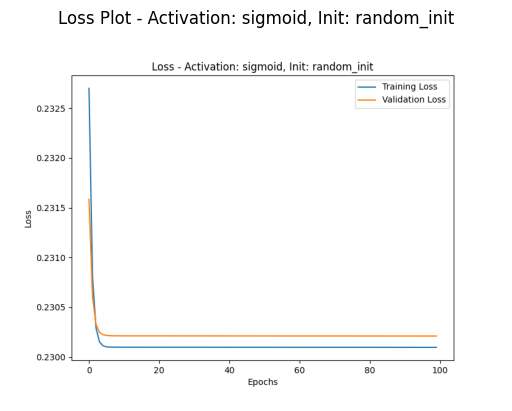

Loaded results for Activation: sigmoid, Initialization: normal_init
Activation: sigmoid, Initialization: normal_init
Test Accuracy: 0.1392


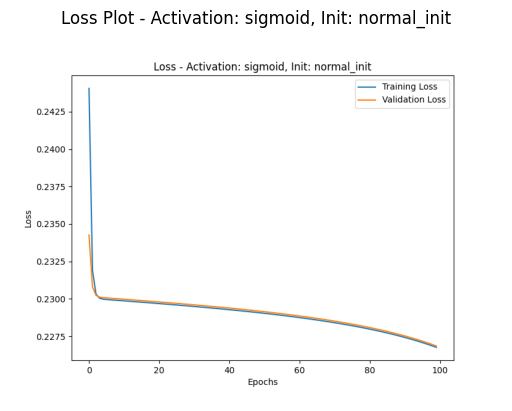

Loaded results for Activation: tanh, Initialization: zero_init
Activation: tanh, Initialization: zero_init
Test Accuracy: 0.1135


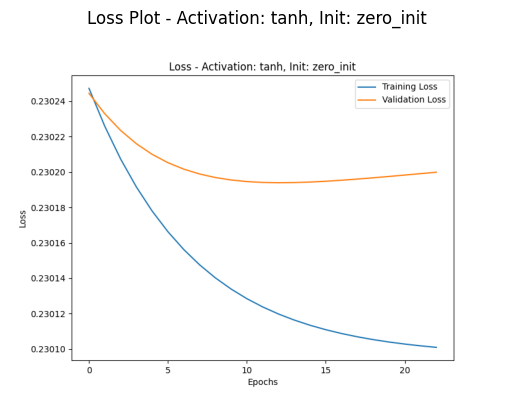

Loaded results for Activation: tanh, Initialization: random_init
Activation: tanh, Initialization: random_init
Test Accuracy: 0.9225


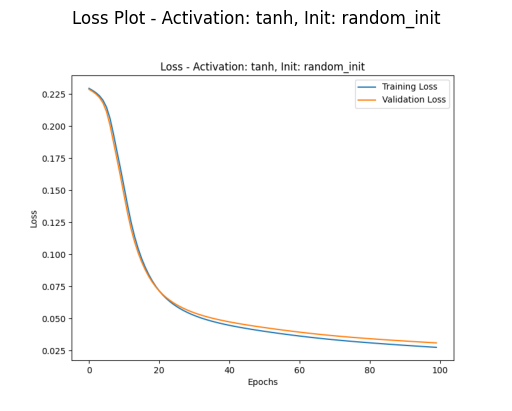

Loaded results for Activation: tanh, Initialization: normal_init
Activation: tanh, Initialization: normal_init
Test Accuracy: 0.9491


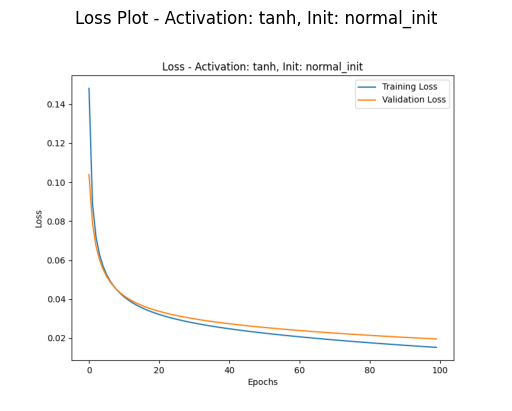

Loaded results for Activation: relu, Initialization: zero_init
Activation: relu, Initialization: zero_init
Test Accuracy: 0.1135


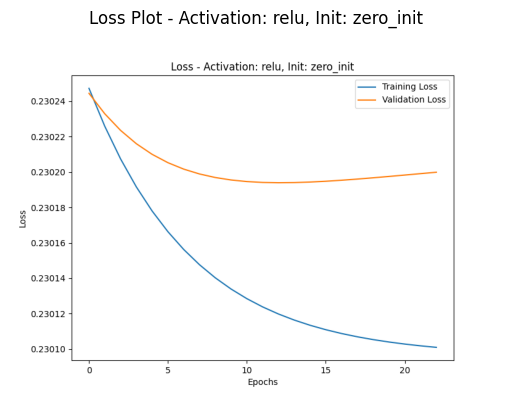

Loaded results for Activation: relu, Initialization: random_init
Activation: relu, Initialization: random_init
Test Accuracy: 0.9388


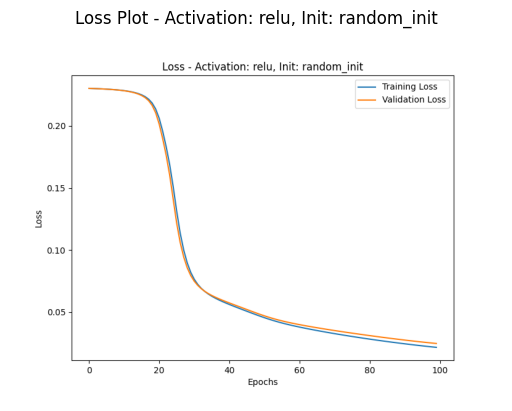

Loaded results for Activation: relu, Initialization: normal_init
Activation: relu, Initialization: normal_init
Test Accuracy: 0.9658


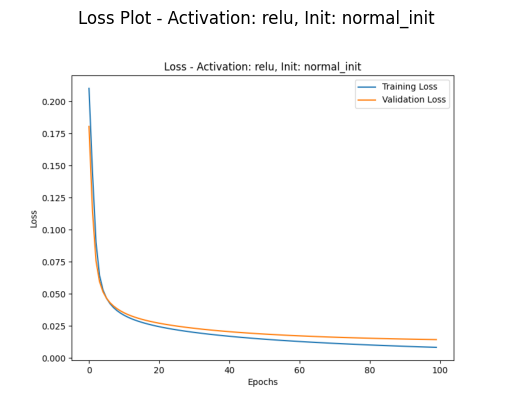

Loaded results for Activation: leaky_relu, Initialization: zero_init
Activation: leaky_relu, Initialization: zero_init
Test Accuracy: 0.1135


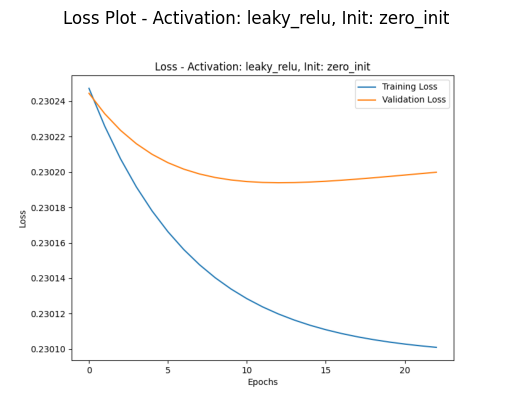

Loaded results for Activation: leaky_relu, Initialization: random_init
Activation: leaky_relu, Initialization: random_init
Test Accuracy: 0.9344


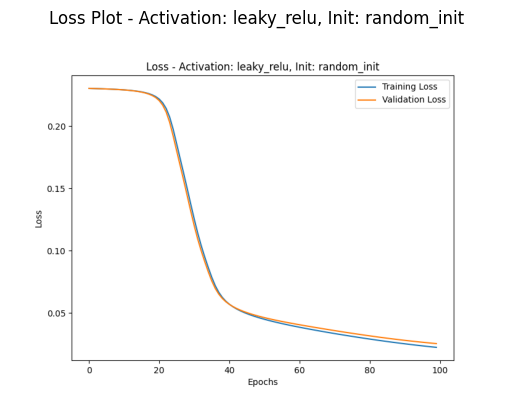

Loaded results for Activation: leaky_relu, Initialization: normal_init
Activation: leaky_relu, Initialization: normal_init
Test Accuracy: 0.9644


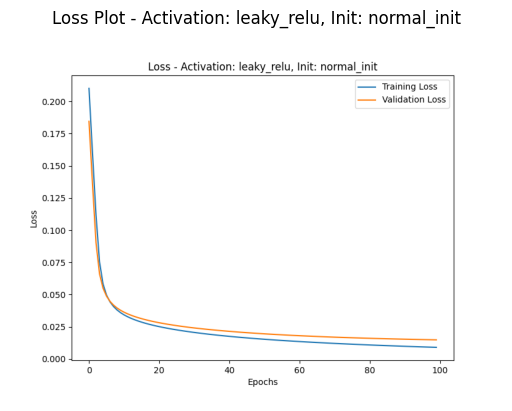

Activation: sigmoid, Initialization: zero_init, Test Accuracy: 0.1135
Activation: sigmoid, Initialization: random_init, Test Accuracy: 0.1135
Activation: sigmoid, Initialization: normal_init, Test Accuracy: 0.1392
Activation: tanh, Initialization: zero_init, Test Accuracy: 0.1135
Activation: tanh, Initialization: random_init, Test Accuracy: 0.9225
Activation: tanh, Initialization: normal_init, Test Accuracy: 0.9491
Activation: relu, Initialization: zero_init, Test Accuracy: 0.1135
Activation: relu, Initialization: random_init, Test Accuracy: 0.9388
Activation: relu, Initialization: normal_init, Test Accuracy: 0.9658
Activation: leaky_relu, Initialization: zero_init, Test Accuracy: 0.1135
Activation: leaky_relu, Initialization: random_init, Test Accuracy: 0.9344
Activation: leaky_relu, Initialization: normal_init, Test Accuracy: 0.9644


In [5]:
results = {}

for activation_fn, activation_derivative in activation:
    for init_fn in weights_init:
        test_accuracy, training_losses, validation_losses = run(
            activation=activation_fn,
            activation_derivative=activation_derivative,
            init_type=init_fn
        )
        
        results[(activation_fn.__name__, init_fn.__name__)] = {
            'test_accuracy': test_accuracy,
            'training_losses': training_losses,
            'validation_losses': validation_losses
        }

for key, value in results.items():
    activation, initialization = key
    print(f"Activation: {activation}, Initialization: {initialization}, Test Accuracy: {value['test_accuracy']:.4f}" )